In [5]:
import pandas as pd
import glob
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# path = r'C:\Users\admin\Documents\Flatiron\capstone\pigskin\data\weekly' # use your path
# all_files = glob.glob(path + "/*.csv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df_weekly = pd.concat(li, axis=0, ignore_index=True)

## Data Loading and Cleaning

In [6]:
#Loading Data
players = pd.read_csv('data/players.csv')
df_games = pd.read_csv('data/weekly/week1.csv')
df_plays = pd.read_csv('data/plays.csv')
df_fo = pd.read_csv('data/2018fo.csv')
df_coverages = pd.read_csv('data/coverages_week1.csv')

In [7]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986022 entries, 0 to 986021
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           986022 non-null  object 
 1   x              986022 non-null  float64
 2   y              986022 non-null  float64
 3   s              986022 non-null  float64
 4   a              986022 non-null  float64
 5   dis            986022 non-null  float64
 6   o              919109 non-null  float64
 7   dir            919109 non-null  float64
 8   event          986022 non-null  object 
 9   nflId          919109 non-null  float64
 10  displayName    986022 non-null  object 
 11  jerseyNumber   919109 non-null  float64
 12  position       919109 non-null  object 
 13  frameId        986022 non-null  int64  
 14  team           986022 non-null  object 
 15  gameId         986022 non-null  int64  
 16  playId         986022 non-null  int64  
 17  playDirection  986022 non-nul

In [8]:
df_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  19239 non-null  int64  
 1   playId                  19239 non-null  int64  
 2   playDescription         19239 non-null  object 
 3   quarter                 19239 non-null  int64  
 4   down                    19239 non-null  int64  
 5   yardsToGo               19239 non-null  int64  
 6   possessionTeam          19239 non-null  object 
 7   playType                19239 non-null  object 
 8   yardlineSide            18985 non-null  object 
 9   yardlineNumber          19239 non-null  int64  
 10  offenseFormation        19098 non-null  object 
 11  personnelO              19210 non-null  object 
 12  defendersInTheBox       19177 non-null  float64
 13  numberOfPassRushers     18606 non-null  float64
 14  personnelD              19210 non-null

In [9]:
df_coverages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gameId    1028 non-null   int64 
 1   playId    1028 non-null   int64 
 2   coverage  1028 non-null   object
dtypes: int64(2), object(1)
memory usage: 24.2+ KB


In [10]:
#Scale EPA to 0-1 min max
df_plays['scaled_epa'] = (df_plays['epa'] - min(df_plays['epa'])) / (max(df_plays['epa']) - min(df_plays['epa']))

EPA is our target variable for this project. In order to better understand and normalize this variable, it has been scaled from 0-1 with a min-max scaling method.

### Merge Datasets 

In [11]:
df_plays_coverage = pd.merge(df_plays,df_coverages,on='playId')
df_plays_final = pd.merge(df_plays_coverage,df_games,on='playId')

In [12]:
df_plays_final.head()

,gameId_x,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playDirection,route
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,left,NaN
1,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,left,NaN
2,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,left,HITCH
3,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,left,NaN
4,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,left,HITCH


In [13]:
df_plays_final.describe()

,gameId_x,playId,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,preSnapVisitorScore,preSnapHomeScore,...,y,s,a,dis,o,dir,nflId,jerseyNumber,frameId,gameId
count,6.520954e+06,6.520954e+06,6.520954e+06,6.520954e+06,6.520954e+06,6.520954e+06,6.501397e+06,6.270639e+06,6.269026e+06,6.269026e+06,...,6.520954e+06,6.520954e+06,6.520954e+06,6.520954e+06,6.077627e+06,6.077627e+06,6.077627e+06,6.077627e+06,6.520954e+06,6.520954e+06
mean,2.018104e+09,2.126561e+03,2.569968e+00,1.921205e+00,8.991291e+00,2.953417e+01,6.090789e+00,4.194722e+00,1.056319e+01,1.194809e+01,...,2.678526e+01,3.176504e+00,2.023461e+00,3.220630e-01,1.804078e+02,1.825569e+02,2.368233e+06,3.777429e+01,3.470656e+01,2.018091e+09
std,1.219229e+04,1.209698e+03,1.109858e+00,8.437040e-01,4.068860e+00,1.236911e+01,9.799847e-01,8.741869e-01,9.810561e+00,9.968781e+00,...,1.110599e+01,2.843237e+00,1.691389e+00,3.074665e-01,1.008404e+02,1.030919e+02,6.153103e+05,2.492407e+01,2.276403e+01,9.205225e+01
min,2.018091e+09,5.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.174000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.060000e+02,1.000000e+00,1.000000e+00,2.018091e+09
25%,2.018091e+09,1.113000e+03,2.000000e+00,1.000000e+00,7.000000e+00,2.100000e+01,6.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,1.905000e+01,8.300000e-01,7.400000e-01,8.000000e-02,9.000000e+01,9.236000e+01,2.533031e+06,2.000000e+01,1.600000e+01,2.018091e+09
50%,2.018101e+09,2.115000e+03,3.000000e+00,2.000000e+00,1.000000e+01,3.000000e+01,6.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01,...,2.679000e+01,2.780000e+00,1.760000e+00,2.800000e-01,1.789900e+02,1.837500e+02,2.550613e+06,2.900000e+01,3.200000e+01,2.018091e+09
75%,2.018113e+09,3.162000e+03,4.000000e+00,3.000000e+00,1.000000e+01,4.000000e+01,7.000000e+00,5.000000e+00,1.700000e+01,1.800000e+01,...,3.465000e+01,4.940000e+00,2.960000e+00,4.900000e-01,2.705300e+02,2.724800e+02,2.556466e+06,5.300000e+01,4.900000e+01,2.018091e+09
max,2.018123e+09,5.511000e+03,5.000000e+00,4.000000e+00,3.000000e+01,5.000000e+01,1.100000e+01,8.000000e+00,4.800000e+01,4.800000e+01,...,6.275000e+01,2.737000e+01,5.833000e+01,7.120000e+00,3.600000e+02,3.600000e+02,2.561485e+06,9.900000e+01,1.720000e+02,2.018091e+09


In [14]:
#Use only data of scenario of when ball is snapped

df_plays_final = df_plays_final[df_plays_final.event == 'ball_snap']
df_plays_final

,gameId_x,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playDirection,route
140,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,ball_snap,310.0,Matt Ryan,2.0,QB,11,away,2018090600,left,NaN
141,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,ball_snap,79848.0,Malcolm Jenkins,27.0,SS,11,home,2018090600,left,NaN
142,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,ball_snap,2495454.0,Julio Jones,11.0,WR,11,away,2018090600,left,HITCH
143,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,ball_snap,2495613.0,Corey Graham,24.0,FS,11,home,2018090600,left,NaN
144,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,ball_snap,2533040.0,Mohamed Sanu,12.0,WR,11,away,2018090600,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6520302,2018090600,4439,(:06) (Shotgun) M.Ryan pass incomplete short r...,4,4,10,ATL,play_type_unknown,PHI,10,...,ball_snap,2555383.0,Jalen Mills,31.0,CB,11,home,2018090600,left,NaN
6520312,2018090600,4439,(:06) (Shotgun) M.Ryan pass incomplete short r...,4,4,10,ATL,play_type_unknown,PHI,10,...,ball_snap,2555415.0,Austin Hooper,81.0,TE,11,away,2018090600,left,NaN
6520322,2018090600,4439,(:06) (Shotgun) M.Ryan pass incomplete short r...,4,4,10,ATL,play_type_unknown,PHI,10,...,ball_snap,2557958.0,Sidney Jones,22.0,CB,11,home,2018090600,left,NaN
6520332,2018090600,4439,(:06) (Shotgun) M.Ryan pass incomplete short r...,4,4,10,ATL,play_type_unknown,PHI,10,...,ball_snap,2560854.0,Calvin Ridley,18.0,WR,11,away,2018090600,left,NaN


### Drop Any Duplicate Rows

In [15]:
df_plays_final = df_plays_final.drop_duplicates(subset='playId', keep="first")

In [16]:
# View Columns
df_plays_final.columns

Index(['gameId_x', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI',
       'scaled_epa', 'gameId_y', 'coverage', 'time', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position',
       'frameId', 'team', 'gameId', 'playDirection', 'route'],
      dtype='object')

In [17]:
df_plays_final.drop(['playDirection','gameId', 'playId', 'playDescription', 'quarter', 'possessionTeam', 'playType','yardlineSide','yardlineNumber','preSnapVisitorScore','preSnapHomeScore','gameClock','absoluteYardlineNumber','penaltyCodes','penaltyJerseyNumbers','passResult','offensePlayResult','playResult','epa','isDefensivePI','time','x','y','s','a','dis','o','dir','event','nflId','displayName','jerseyNumber','position','frameId','team','gameId','typeDropback'], axis=1, inplace=True)
df_plays_final

C:\Users\admin\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,gameId_x,down,yardsToGo,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,scaled_epa,gameId_y,coverage,route
140,2018090600,1,15,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",0.593125,2018090600,Cover 3 Zone,NaN
8400,2018090600,1,10,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",0.562287,2018090600,Cover 3 Zone,NaN
11830,2018090600,2,10,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0.546221,2018090600,Cover 3 Zone,NaN
15862,2018090600,3,10,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",0.728582,2018090600,Cover 3 Zone,NaN
20952,2018090600,3,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",0.539438,2018090600,Cover 0 Man,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6502052,2018102109,3,6,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,5.0,"3 DL, 3 LB, 5 DB",0.647199,2018090905,Cover 3 Zone,NaN
6508944,2018110406,1,10,EMPTY,"0 RB, 1 TE, 4 WR",5.0,4.0,"2 DL, 4 LB, 5 DB",0.555701,2018091001,Cover 2 Zone,NaN
6510238,2018111109,3,11,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,3.0,"3 DL, 2 LB, 6 DB",0.531582,2018090902,Cover 1 Man,NaN
6517488,2018111803,3,10,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,5.0,"3 DL, 3 LB, 5 DB",0.726311,2018090906,Cover 4 Zone,NaN


## Exploratory Data Analysis

First, we want to take a look at the offensive side of the ball, since these are the features we are going to use to predict our target variable. It's important to see which formations are mostly on offense and with which personnel. 

Breaking down the types of formations used on offense, 

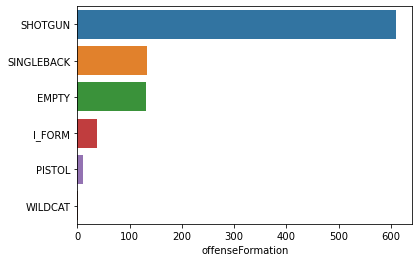

In [18]:
# Breakdown of Playtypes
sns.barplot(y=df_plays_final['offenseFormation'].value_counts().index,x=df_plays_final['offenseFormation'].value_counts())

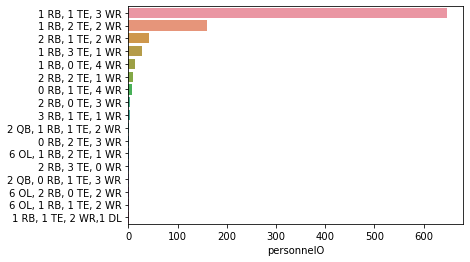

In [22]:
sns.barplot(y=df_plays_final['personnelO'].value_counts().index,x=df_plays_final['personnelO'].value_counts(),orient='h')

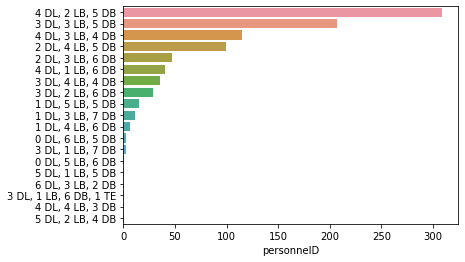

In [23]:
# Breakdown of Defensive Personnel
sns.barplot(y=df_plays_final['personnelD'].value_counts().index,x=df_plays_final['personnelD'].value_counts(),orient='h')

In [24]:
df_plays_final.loc[df_plays_final['personnelD'] == '0 DL, 6 LB, 5 DB']

,gameId_x,down,yardsToGo,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,scaled_epa,gameId_y,coverage,route
2420582,2018090900,3,11,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,5.0,"0 DL, 6 LB, 5 DB",0.489234,2018090900,Cover 3 Zone,NaN
2759522,2018090900,3,7,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,6.0,"0 DL, 6 LB, 5 DB",0.486291,2018090900,Cover 1 Man,NaN


In [25]:
#Average EPA by Coverage
df_plays_final.groupby(['coverage'])['scaled_epa'].agg(['mean'])

,mean
coverage,
Cover 0 Man,0.568424
Cover 1 Man,0.574963
Cover 2 Man,0.564306
Cover 2 Zone,0.573649
Cover 3 Zone,0.570062
Cover 4 Zone,0.578251
Cover 6 Zone,0.573273
Prevent Zone,0.524001


For the below, I wanted to see if specific coverages were tied to specific offensive personnel schemes, that way it would be easier to develop a recommendation. However, it looks like from the below, there are issues with that and teams run multiple personnel schemes with defensive coverages. For our initial MVP, we will work with finding out best coverage and then work into using personnel. Maybe, go back to using just personnel breakdowns. 

In [33]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df_plays_final.groupby(['coverage','personnelD'])['gameId_x'].agg(['count'])

count
coverage     personnelD                   
Cover 0 Man  3 DL, 3 LB, 5 DB            1
             3 DL, 4 LB, 4 DB            2
             4 DL, 1 LB, 6 DB            2
             4 DL, 2 LB, 5 DB            3
             4 DL, 3 LB, 4 DB            2
             6 DL, 3 LB, 2 DB            1
Cover 1 Man  0 DL, 5 LB, 6 DB            1
             0 DL, 6 LB, 5 DB            1
             1 DL, 3 LB, 7 DB            1
             1 DL, 4 LB, 6 DB            2
             1 DL, 5 LB, 5 DB            6
             2 DL, 3 LB, 6 DB           17
             2 DL, 4 LB, 5 DB           27
             3 DL, 2 LB, 6 DB            8
             3 DL, 3 LB, 5 DB           62
             3 DL, 4 LB, 4 DB           12
             4 DL, 1 LB, 6 DB           13
             4 DL, 2 LB, 5 DB           78
             4 DL, 3 LB, 4 DB           38
             4 DL, 4 LB, 3 DB            1
Cover 2 Man  1 DL, 3 LB, 7 DB            3
             1 DL, 5 LB, 5 DB            1
             2 DL, 3 LB, 6 DB            3
             2 DL, 4 LB, 5 DB            2
             3 DL, 2 LB, 6 DB            3
             3 DL, 3 LB, 5 DB            8
             4 DL, 1 LB, 6 DB            1
             4 DL, 2 LB, 5 DB            8
             4 DL, 3 LB, 4 DB            1
Cover 2 Zone 1 DL, 4 LB, 6 DB            2
             1 DL, 5 LB, 5 DB            1
             2 DL, 3 LB, 6 DB            6
             2 DL, 4 LB, 5 DB            8
             3 DL, 2 LB, 6 DB            7
             3 DL, 3 LB, 5 DB           27
             3 DL, 4 LB, 4 DB            5
             4 DL, 2 LB, 5 DB           30
             4 DL, 3 LB, 4 DB           12
             5 DL, 1 LB, 5 DB            1
Cover 3 Zone 0 DL, 6 LB, 5 DB            1
             1 DL, 3 LB, 7 DB            4
             1 DL, 4 LB, 6 DB            2
             1 DL, 5 LB, 5 DB            3
             2 DL, 3 LB, 6 DB           11
             2 DL, 4 LB, 5 DB           43
             3 DL, 1 LB, 7 DB            1
             3 DL, 2 LB, 6 DB            6
             3 DL, 3 LB, 5 DB           70
             3 DL, 4 LB, 4 DB            8
             4 DL, 1 LB, 6 DB           15
             4 DL, 2 LB, 5 DB          113
             4 DL, 3 LB, 4 DB           39
             5 DL, 2 LB, 4 DB            1
Cover 4 Zone 1 DL, 3 LB, 7 DB            2
             1 DL, 5 LB, 5 DB            1
             2 DL, 3 LB, 6 DB            9
             2 DL, 4 LB, 5 DB           11
             3 DL, 1 LB, 7 DB            1
             3 DL, 2 LB, 6 DB            2
             3 DL, 3 LB, 5 DB           24
             3 DL, 4 LB, 4 DB            3
             4 DL, 1 LB, 6 DB            8
             4 DL, 2 LB, 5 DB           59
             4 DL, 3 LB, 4 DB           16
Cover 6 Zone 1 DL, 3 LB, 7 DB            1
             1 DL, 5 LB, 5 DB            3
             2 DL, 3 LB, 6 DB            1
             2 DL, 4 LB, 5 DB            8
             3 DL, 2 LB, 6 DB            3
             3 DL, 3 LB, 5 DB           15
             3 DL, 4 LB, 4 DB            5
             4 DL, 1 LB, 6 DB            1
             4 DL, 2 LB, 5 DB           18
             4 DL, 3 LB, 4 DB            7
Prevent Zone 3 DL, 1 LB, 6 DB, 1 TE      1

In [27]:
pd.set_option("display.max_rows", 101)
df_plays_final.groupby(['personnelD','yardsToGo'])['scaled_epa'].agg(['mean'])

mean
personnelD       yardsToGo          
0 DL, 5 LB, 6 DB 7          0.499642
0 DL, 6 LB, 5 DB 7          0.486291
                 11         0.489234
1 DL, 3 LB, 7 DB 3          0.515614
                 4          0.404880
...                              ...
4 DL, 3 LB, 4 DB 23         0.578292
4 DL, 4 LB, 3 DB 1          0.640030
5 DL, 1 LB, 5 DB 9          0.662653
5 DL, 2 LB, 4 DB 13         0.537468
6 DL, 3 LB, 2 DB 1          0.539438

[164 rows x 1 columns]

In [28]:
df_plays_final

,gameId_x,down,yardsToGo,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,scaled_epa,gameId_y,coverage,route
140,2018090600,1,15,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",0.593125,2018090600,Cover 3 Zone,NaN
8400,2018090600,1,10,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",0.562287,2018090600,Cover 3 Zone,NaN
11830,2018090600,2,10,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0.546221,2018090600,Cover 3 Zone,NaN
15862,2018090600,3,10,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",0.728582,2018090600,Cover 3 Zone,NaN
20952,2018090600,3,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",0.539438,2018090600,Cover 0 Man,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6502052,2018102109,3,6,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,5.0,"3 DL, 3 LB, 5 DB",0.647199,2018090905,Cover 3 Zone,NaN
6508944,2018110406,1,10,EMPTY,"0 RB, 1 TE, 4 WR",5.0,4.0,"2 DL, 4 LB, 5 DB",0.555701,2018091001,Cover 2 Zone,NaN
6510238,2018111109,3,11,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,3.0,"3 DL, 2 LB, 6 DB",0.531582,2018090902,Cover 1 Man,NaN
6517488,2018111803,3,10,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,5.0,"3 DL, 3 LB, 5 DB",0.726311,2018090906,Cover 4 Zone,NaN


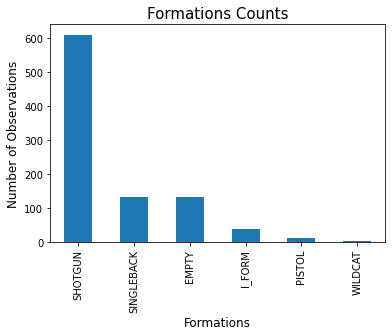

In [29]:
#Number of times Offensive Formation used
chart = df_plays_final['offenseFormation'].value_counts().plot(kind='bar');
chart.set_title('Formations Counts', fontsize=15);
chart.set_ylabel('Number of Observations', fontsize=12);
chart.set_xlabel('Formations', fontsize=12);

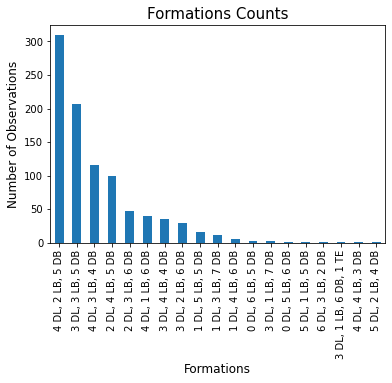

In [31]:
chart = df_plays_final['personnelD'].value_counts().plot(kind='bar');
chart.set_title('Formations Counts', fontsize=15);
chart.set_ylabel('Number of Observations', fontsize=12);
chart.set_xlabel('Formations', fontsize=12);

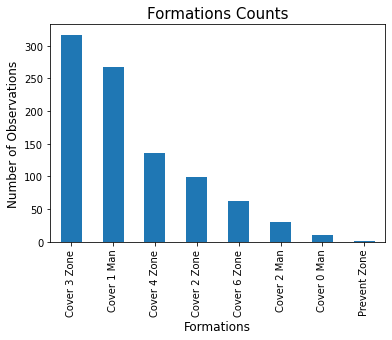

In [32]:
chart = df_plays_final['coverage'].value_counts().plot(kind='bar');
chart.set_title('Formations Counts', fontsize=15);
chart.set_ylabel('Number of Observations', fontsize=12);
chart.set_xlabel('Formations', fontsize=12);

Cover 3 Zone is one of the most popular formations in football. It is also one of the most basic coverages in football. In years prior, people thought it was elementary and used mainly for high school football, however, the Seattle Seahawks popularized this coverage scheme. The coverage is used frequently because it is balanced against both the run and pass offense. 

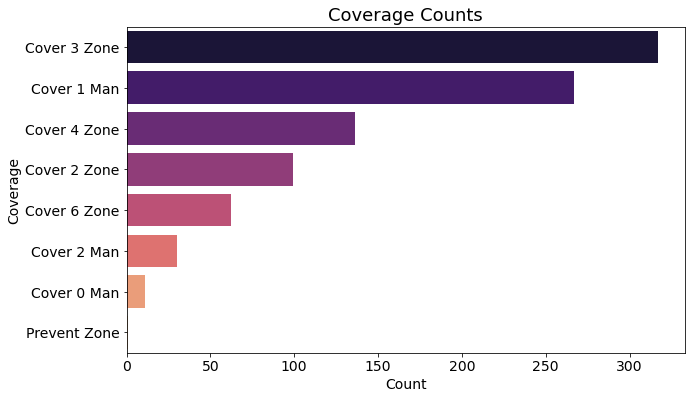

In [33]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['coverage'].value_counts().index, x=df_plays_final['coverage'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("Count", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Coverage Counts", fontdict={'fontsize':18});

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['coverage'].value_counts().index, x=df_plays_final['coverage'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("Count", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Coverage Counts", fontdict={'fontsize':18});

From below, we can see the commonly used defensive personnel scheme is a 4-2-5 or (4 DB, 2 LB, 5 DB). One of the biggest strengths of this defensive personnel is that it employs five defensive backs. With 5 defensive backs, your defense is able to be versatile in stopping the run and applying pressue to prevent the pass.

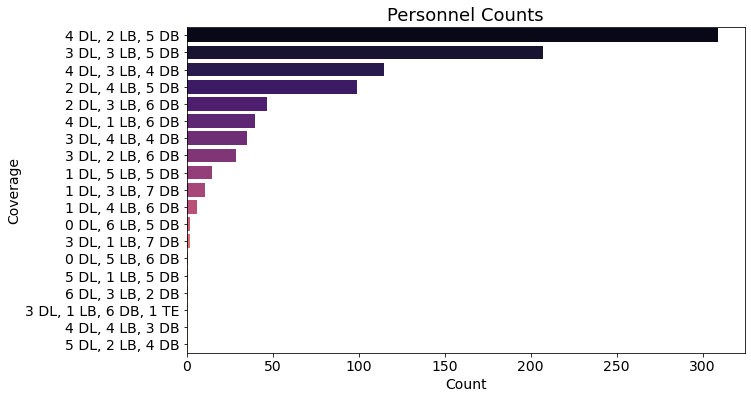

In [34]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['personnelD'].value_counts().index, x=df_plays_final['personnelD'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("Count", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Personnel Counts", fontdict={'fontsize':18});

The 1 RB, 1 TE, 3 WR is also most widely known to be the common sets on the offensive side of football. With the exception of a few teams such as the San Francisco 49ers, most teams utilize this set quite often.

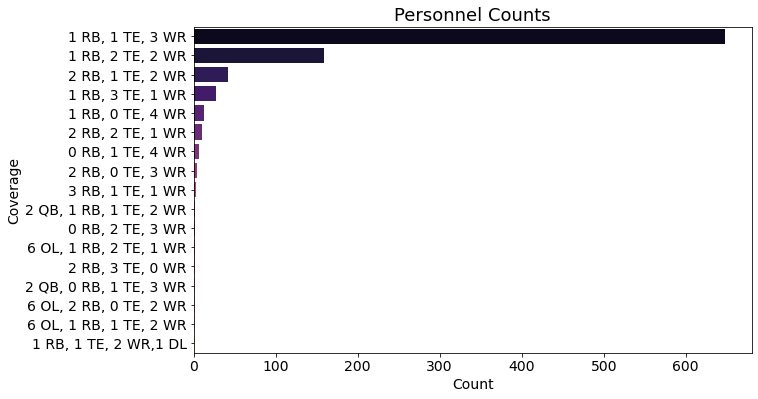

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['personnelO'].value_counts().index, x=df_plays_final['personnelO'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("Count", fontdict={'fontsize':14});
plt.ylabel("Coverage", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Personnel Counts", fontdict={'fontsize':18});

According to the below, numbers of defenders in the box is 6 most of the time. 

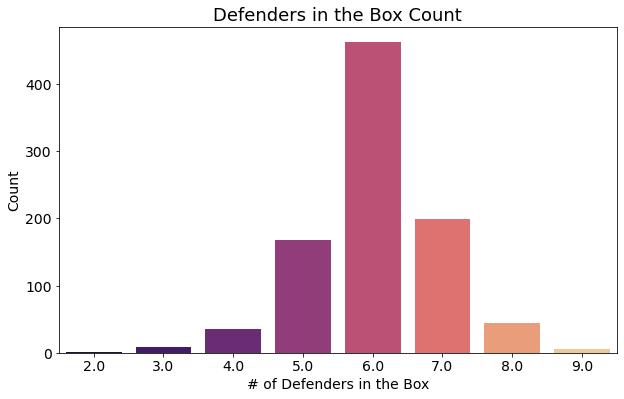

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_plays_final['defendersInTheBox'].value_counts().index, y=df_plays_final['defendersInTheBox'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("# of Defenders in the Box", fontdict={'fontsize':14});
plt.ylabel("Count", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("Defenders in the Box Count", fontdict={'fontsize':18});

Number of pass rushers is by far and away 6. Obviously there will be very rare scenarios such as late game scenarios where the defense will send maybe only 2-3. 

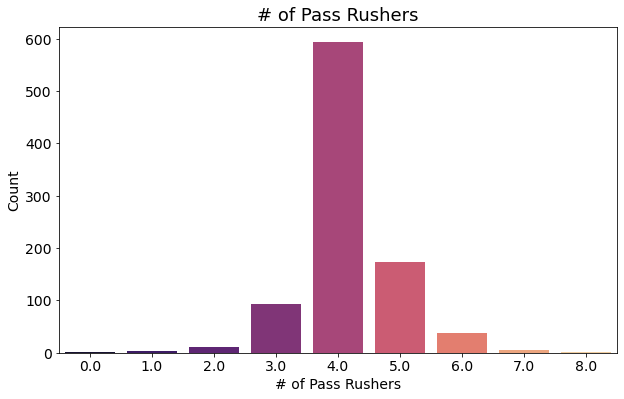

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_plays_final['numberOfPassRushers'].value_counts().index, y=df_plays_final['numberOfPassRushers'].value_counts(), estimator=np.median, palette="magma")
plt.xlabel("# of Pass Rushers", fontdict={'fontsize':14});
plt.ylabel("Count", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("# of Pass Rushers", fontdict={'fontsize':18});

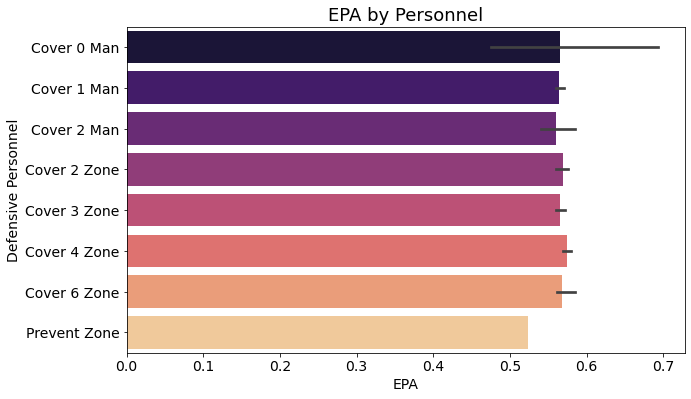

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['coverage'].sort_values(), x=df_plays_final['scaled_epa'], estimator=np.median, palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("Defensive Personnel", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("EPA by Personnel", fontdict={'fontsize':18});

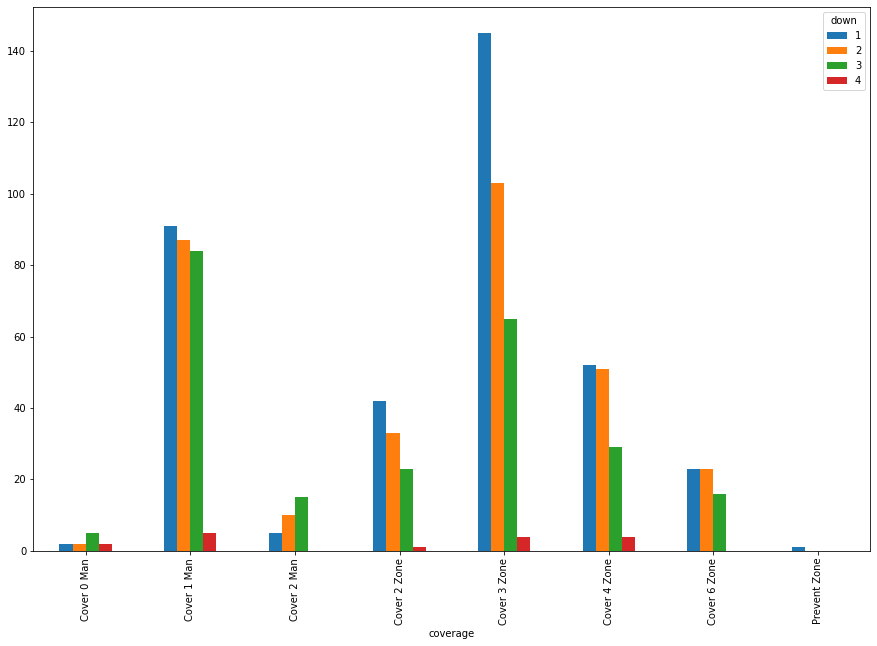

In [41]:
df_plot = df_plays_final.groupby(['coverage', 'down']).size().unstack(level=1)
df_plot.plot(kind = 'bar',figsize=(15,10))

<Figure size 2160x2160 with 0 Axes>

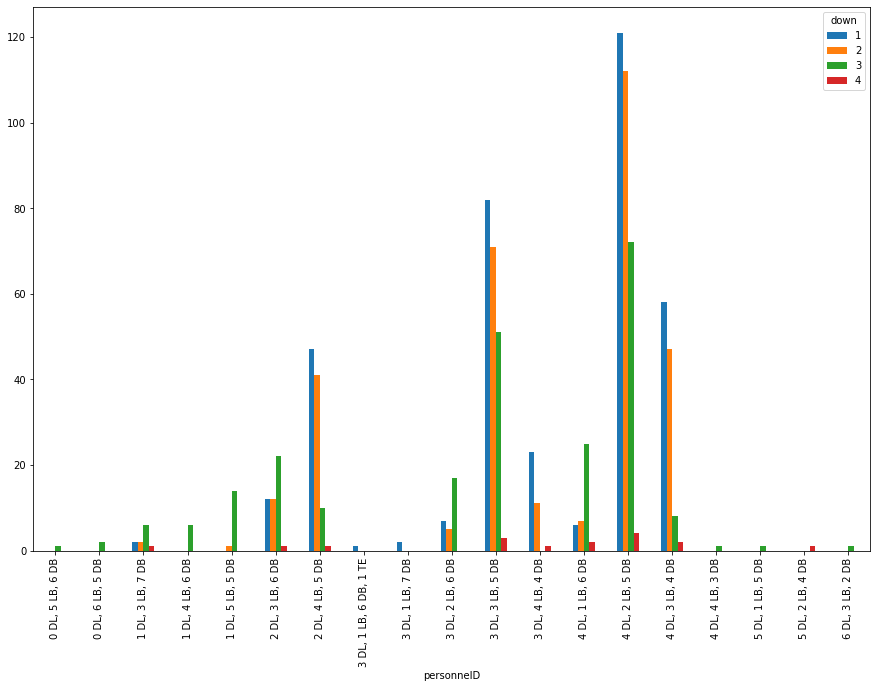

In [39]:
df_plot = df_plays_final.groupby(['personnelD', 'down']).size().unstack(level=1)
plt.figure(figsize=(30,30))
df_plot.plot(kind = 'bar',figsize=(15,10))


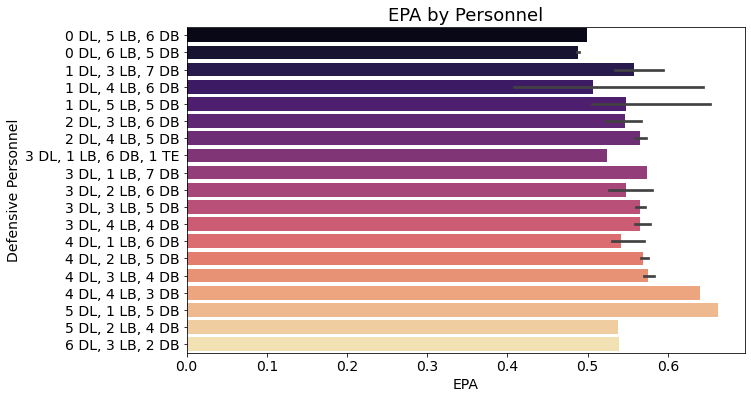

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['personnelD'].sort_values(), x=df_plays_final['scaled_epa'], estimator=np.median, palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("Defensive Personnel", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("EPA by Personnel", fontdict={'fontsize':18});

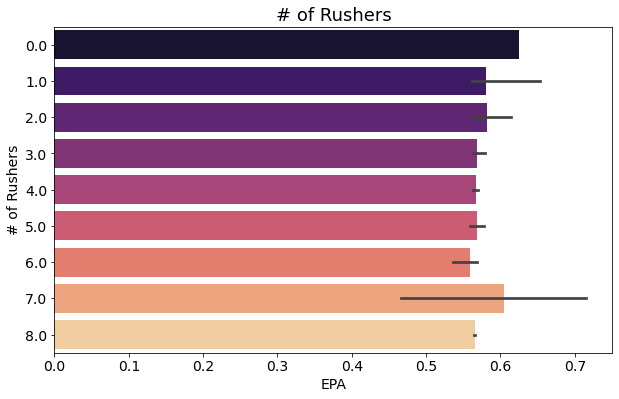

In [38]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['numberOfPassRushers'].sort_values(), x=df_plays_final['scaled_epa'],orient='h', estimator=np.median,palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("# of Rushers", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("# of Rushers", fontdict={'fontsize':18});

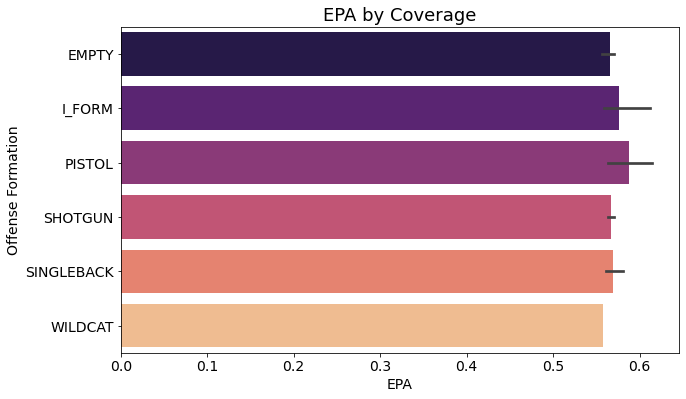

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(y=df_plays_final['offenseFormation'].sort_values(), x=df_plays_final['scaled_epa'], estimator=np.median,palette="magma")
plt.xlabel("EPA", fontdict={'fontsize':14});
plt.ylabel("Offense Formation", fontdict={'fontsize':14});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("EPA by Coverage", fontdict={'fontsize':18});

In [43]:
#Create Dummy columns
df_plays_final
oform_dummies = pd.get_dummies(df_plays_final['offenseFormation'], drop_first=True)
opersonnel_dummies = pd.get_dummies(df_plays_final['personnelO'], drop_first=True)
# dropback_dummies = pd.get_dummies(df_plays_final['typeDropback'],drop_first=True)
coverage_dummies = pd.get_dummies(df_plays_final['coverage'],drop_first=True)
df_main = pd.concat([df_plays_final, oform_dummies,opersonnel_dummies,coverage_dummies], axis=1)

In [44]:
df_main
df_main.columns

Index(['gameId_x', 'down', 'yardsToGo', 'offenseFormation', 'personnelO',
       'defendersInTheBox', 'numberOfPassRushers', 'personnelD', 'scaled_epa',
       'gameId_y', 'coverage', 'route', 'I_FORM', 'PISTOL', 'SHOTGUN',
       'SINGLEBACK', 'WILDCAT', '0 RB, 2 TE, 3 WR', '1 RB, 0 TE, 4 WR',
       '1 RB, 1 TE, 2 WR,1 DL', '1 RB, 1 TE, 3 WR', '1 RB, 2 TE, 2 WR',
       '1 RB, 3 TE, 1 WR', '2 QB, 0 RB, 1 TE, 3 WR', '2 QB, 1 RB, 1 TE, 2 WR',
       '2 RB, 0 TE, 3 WR', '2 RB, 1 TE, 2 WR', '2 RB, 2 TE, 1 WR',
       '2 RB, 3 TE, 0 WR', '3 RB, 1 TE, 1 WR', '6 OL, 1 RB, 1 TE, 2 WR',
       '6 OL, 1 RB, 2 TE, 1 WR', '6 OL, 2 RB, 0 TE, 2 WR', 'Cover 1 Man',
       'Cover 2 Man', 'Cover 2 Zone', 'Cover 3 Zone', 'Cover 4 Zone',
       'Cover 6 Zone', 'Prevent Zone'],
      dtype='object')

In [45]:
#Drop old categorical columns
df_main.drop(['gameId_x','personnelD','gameId_y','coverage','personnelO','offenseFormation','route'], axis=1, inplace=True)

In [46]:
#Drop NA Values, very little in dataset
df_main.dropna(inplace=True)

## Setup Target Variable

In [47]:
# Our Target Variable is EPA and our features are all the other columns
y = df_main['scaled_epa']
X = df_main.drop(['scaled_epa'], axis=1)

Below is our list of features generated by our initial game situation numbers and categorical variables converted to Dummy columns

In [48]:
# Train Test Split my data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

## Run Regression Models

### 1st Model: Linear Regression

First model is a linear regression model. I am currently using the above columns shown in the df_main table as my features. RMSE comes out to about .00587

In [49]:
# Instantiate Model
linreg = LinearRegression()

# Fit to Training Data
lr_1 = linreg.fit(X_train, y_train)

# Predict on Test Set
y_pred = linreg.predict(X_test)

#Calculate MSE/RMSE
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

MSE:  0.005889946554843216
RMSE:  0.002944973277421608


In [50]:
#poly = PolynomialFeatures(degree=2, include_bias=False)
#poly_data = poly.fit_transform(df_features)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(df_poly, target, random_state=9,test_size=0.2)

In [51]:
# # instantiate a linear regression object
# lm_2 = LinearRegression()

# #fit the linear regression to the data
# lm_2 = lm_3.fit(X_train2, y_train2)

# # Predict on Test Set
# y_pred = lm_2.predict(X_test)

# mse = mean_squared_error(y_test,y_pred)
# print("MSE: ", mse)
# print("RMSE: ", mse*(1/2.0)) 

### 2nd Model: DecisionTreeRegression Model

2nd Model was a DecisionTreeRegressor model using the default parameters. RMSE came out to a significantly higher value of 0.019. We will be dropping this model for now. 

In [52]:
# Instantiate Model
DecisionTreeRegModel = DecisionTreeRegressor()

# Fit to Training Data
DecisionTreeRegModel.fit(X_train, y_train)

# Predict on Test Set
y_pred = DecisionTreeRegModel.predict(X_test)
y_pred

#Calculate MSE/RMSE
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

MSE:  0.011704655819179947
RMSE:  0.005852327909589974


### Random Forest Regression Model

In [53]:
# Instantiate Model
rfr = RandomForestRegressor()
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

# Fit to Training Data
rfr.fit(X_train, y_train)

# Predict on Test Set
y_pred = rfr.predict(X_test)

#Calculate MSE/RMSE
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

MSE:  0.007531078873540374
RMSE:  0.003765539436770187


### Gradiest Boosting Regressor Model

In [54]:
# Instantiate Model
gbr = GradientBoostingRegressor()

# Fit to Training Data
gbr.fit(X_train, y_train)

# Fit to Training Data
y_pred = gbr.predict(X_test)

#Calculate MSE/RMSE
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

MSE:  0.006656934630158241
RMSE:  0.0033284673150791207


### XGBoost

In [55]:
# Instantiate Model
xgr = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Instantiate Model
xgr.fit(X_train,y_train)

# Fit to Training Data
y_pred = xgr.predict(X_test)

#Calculate MSE/RMSE
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

[08:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
MSE:  0.007277830184006397
RMSE:  0.0036389150920031984


### GridSearch

In [56]:
## Setup Parameters For GridSearch
parameters={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200,500], 
            'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'max_depth': [1,2,3,4,5,6,7,8,9,10], 
            #'min_samples_leaf': [np.linspace(0.1, 1.0, 10, endpoint=True)], 
            'max_features': list(range(1,df_main.shape[1]))} 

In [57]:
# Run GridSearch
grid_GBR = GridSearchCV(estimator=gbr, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200,
                                          500]})

In [58]:
# Find Results from GridSearch
print(" Results from GridSearch " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from GridSearch 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.5, max_depth=4, max_features=8,
                          n_estimators=1)

 The best score across ALL searched params:
 0.032451231783005574

 The best parameters across ALL searched params:
 {'learning_rate': 0.5, 'max_depth': 4, 'max_features': 8, 'n_estimators': 1}


In [59]:
# Re-run GBR with New Params
gbr = GradientBoostingRegressor(learning_rate= 0.5, max_depth= 4, max_features= 8, n_estimators= 1)

# Fit to Training Data
gbr.fit(X_train, y_train)

# Predict on Test Set
y_pred = gbr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

MSE:  0.005396802332213856
RMSE:  0.002698401166106928


In [72]:
# Setup Parameters for GridSearch on XGR
params = {'learning_rate': [.03, 0.05, .07, 0.10, 0.15], #so called `eta` value
              'max_depth': range (2, 10, 1),
              'min_child_weight': [1, 3, 5, 10],
              'n_estimators': [100,300,500]}

In [61]:
# Instantiate and Fit on Training Data
grid_xgr = GridSearchCV(estimator=xgr, param_grid = params, cv = 2, n_jobs=-1)
grid_xgr.fit(X_train, y_train)

[21:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.3, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=10, n_jobs=0,
                                    num_parallel_tree=1, objective='reg:linear',
                                    random_state=0, reg_alpha=10, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                               

In [62]:
# Find reuslts of GridSearch
print(" Results from GridSearch " )
print("\n The best estimator across ALL searched params:\n",grid_xgr.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xgr.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgr.best_params_)

 Results from GridSearch 

 The best estimator across ALL searched params:
 XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=2,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 -0.11760314097096913

 The best parameters across ALL searched params:
 {'learning_rate': 0.15, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100}


In [82]:
xgr = xgb.XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.3, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.15, max_delta_step=0,
                                    max_depth=2, min_child_weight=5,
                                    monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, objective='reg:linear',
                                    random_state=0, reg_alpha=10, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None)

xgr.fit(X_train,y_train)

y_pred = xgr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

[21:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
MSE:  0.005856189519391615
RMSE:  0.0029280947596958076


### View Predictions

In [60]:
# Merge Predictions with Actuals
reset = y_test.reset_index()
df_preds = pd.concat([reset,pd.Series(y_pred)],axis=1).rename(columns={0:'Y Test Preds'})
df_preds

,index,scaled_epa,Y Test Preds
0,5747279,0.606467,0.568996
1,6104362,0.548169,0.568996
2,1222484,0.557346,0.568996
3,6158297,0.600316,0.568996
4,3332566,0.613378,0.571172
5,4445779,0.548218,0.571172
6,2523972,0.502616,0.568996
7,576392,0.577065,0.568996
8,4937851,0.496988,0.568996
9,1973352,0.651627,0.568996


### Test Our Model Inputs, Work in Progress

Next Step, develop simple way to input all the below criteria and output an estimated EPA.

In [61]:
df_column_check = df_main.drop(['scaled_epa'], axis=1)

In [62]:
df_column_check.columns.tolist()

['down',
 'yardsToGo',
 'defendersInTheBox',
 'numberOfPassRushers',
 'I_FORM',
 'PISTOL',
 'SHOTGUN',
 'SINGLEBACK',
 'WILDCAT',
 '0 RB, 2 TE, 3 WR',
 '1 RB, 0 TE, 4 WR',
 '1 RB, 1 TE, 2 WR,1 DL',
 '1 RB, 1 TE, 3 WR',
 '1 RB, 2 TE, 2 WR',
 '1 RB, 3 TE, 1 WR',
 '2 QB, 0 RB, 1 TE, 3 WR',
 '2 QB, 1 RB, 1 TE, 2 WR',
 '2 RB, 0 TE, 3 WR',
 '2 RB, 1 TE, 2 WR',
 '2 RB, 2 TE, 1 WR',
 '2 RB, 3 TE, 0 WR',
 '3 RB, 1 TE, 1 WR',
 '6 OL, 1 RB, 1 TE, 2 WR',
 '6 OL, 1 RB, 2 TE, 1 WR',
 '6 OL, 2 RB, 0 TE, 2 WR',
 'Cover 1 Man',
 'Cover 2 Man',
 'Cover 2 Zone',
 'Cover 3 Zone',
 'Cover 4 Zone',
 'Cover 6 Zone',
 'Prevent Zone']

In [63]:
gbr.predict(['1','15','4','7','0','0','1','0','0','0','0','0','1','0','0','0','0','0','0','0','0','0','0','0','0','1','0','0','0','0','0','0'])
gbr.predict(['1','15','4','7','0','0','1','0','0','0','0','0','1','0','0','0','0','0','0','0','0','0','0','0','0','0','1','0','0','0','0','0'])
gbr.predict(['1','15','4','7','0','0','1','0','0','0','0','0','1','0','0','0','0','0','0','0','0','0','0','0','0','0','0','1','0','0','0','0'])
gbr.predict(['1','15','4','7','0','0','1','0','0','0','0','0','1','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','1','0','0','0']) 
gbr.predict(['1','15','4','7','0','0','1','0','0','0','0','0','1','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','1','0','0'])  
gbr.predict(['1','15','4','7','0','0','1','0','0','0','0','0','1','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','1','0'])  
gbr.predict(['1','15','4','7','0','0','1','0','0','0','0','0','1','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','0','1'])  

ValueError: Expected 2D array, got 1D array instead:
array=[ 1. 15.  4.  7.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.